In [ ]:
# SETTING UP THE ENVIRONMENT
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import zipfile
import json
from pathlib import Path

# TensorFlow and Keras Components
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from tensorflow.keras.optimizers import Adam

# Hugging Face Transformers
from transformers import AutoTokenizer, TFBertModel, logging as hf_logging

# Scikit-learn for ML Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# Google Colab Specifics
from google.colab import files, drive

# Suppress less critical warnings from Transformers.
hf_logging.set_verbosity_error()
print(" All libraries are installed and imported successfully.")


# DATA LOADING AND PREPARATION
print("\n 1: Loading and Preparing the Dataset")
try:
    uploaded = files.upload()
    with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
    print("Dataset unzipped successfully into '/content/data'.")
except Exception as e:
    print(f" An error occurred: {e}. Please upload 'archive.zip'.")

try:
    fake_df = pd.read_csv('/content/data/Fake.csv')
    true_df = pd.read_csv('/content/data/True.csv')
    print(" CSV files loaded into DataFrames.")
except FileNotFoundError:
    print(" Error: Could not find the CSV files.")
    exit()

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

true_df['text'] = true_df['text'].apply(lambda x: x.split(' - ', 1)[-1])
fake_df['label'] = 1
true_df['label'] = 0
df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

X_train, X_temp, Y_train, Y_temp = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)
print("\n--- Test Data Ready for Evaluation ---")
print(f"Test data: {len(X_test)} samples")


 All libraries are installed and imported successfully.

--- Section 1: Loading and Preparing the Dataset ---


Saving archive.zip to archive.zip
Dataset unzipped successfully into '/content/data'.
 CSV files loaded into DataFrames.

--- Test Data Ready for Evaluation ---
Test data: 4490 samples


In [ ]:
# 2: LOADING THE PRE-TRAINED MODEL AND TOKENIZER
print("\n 2: Loading Saved Model and Tokenizer ")

# Mount Google Drive to access artifacts
from google.colab import drive
drive.mount('/content/drive')

# Define the Path to Your Saved Artifacts
ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN")
if not ARTIFACTS_DIR.exists():
    raise FileNotFoundError(f"Critical Error: The artifact directory was not found at {ARTIFACTS_DIR}")

# Load the PRE-DEFINED Test Set
print("\n Loading the Held-Out Test Set for Evaluation ")
test_data_path = ARTIFACTS_DIR / "test_data.csv"
if not test_data_path.exists():
    raise FileNotFoundError(f"Critical Error: Test data file 'test_data.csv' not found in {ARTIFACTS_DIR}")

# Load the test set used during training
test_df = pd.read_csv(test_data_path)
X_test = test_df['content']
Y_test = test_df['label']
print(f" Consistent test data loaded successfully: {len(X_test)} samples")


# Load Model Configuration
print("\n Loading Saved Model and Tokenizer")
config_path = ARTIFACTS_DIR / "config.json"
if config_path.exists():
    config = json.loads(config_path.read_text())
    print("-> Model configuration loaded from 'config.json'.")
else:
    # Fallback if config is missing
    config = {"model_name": "bert-base-uncased", "max_len": 128, "threshold": 0.5}
    print("[Warning] 'config.json' not found. Using default parameters.")

model_name = config.get("model_name")
max_len = int(config.get("max_len"))
threshold = float(config.get("threshold", 0.5))

# Load the Tokenizer
tokenizer_dir = ARTIFACTS_DIR / "tokenizer"
if not tokenizer_dir.exists():
     raise FileNotFoundError(f"Critical Error: Tokenizer directory not found at {tokenizer_dir}")
tokenizer = AutoTokenizer.from_pretrained(str(tokenizer_dir))
print("-> Tokenizer loaded successfully.")

# Redefine the Custom Layer for Model Loading
class BertFeatureExtractor(Layer):
    def __init__(self, model_name='bert-base-uncased', **kwargs):
        super(BertFeatureExtractor, self).__init__(**kwargs)
        self.model_name = model_name
        self.bert = TFBertModel.from_pretrained(self.model_name, from_pt=True)
        self.bert.trainable = False
    def call(self, inputs):
        return self.bert(inputs).last_hidden_state
    def get_config(self):
        config = super().get_config()
        config.update({"model_name": self.model_name})
        return config

# Load the Full Model
model_path = ARTIFACTS_DIR / "model.keras"
if not model_path.exists():
    raise FileNotFoundError(f"Critical Error: Model file 'model.keras' not found in {ARTIFACTS_DIR}")

model = load_model(
    model_path,
    custom_objects={"BertFeatureExtractor": BertFeatureExtractor}
)
print("-> Full model loaded successfully from .keras file.")

print("\n--- Model Reload Summary ---")
print(f"   Model reloaded from: {ARTIFACTS_DIR}")
print(f"   Max Length:          {max_len}")
print(f"   Classification Threshold: {threshold}")
model.summary()



 2: Loading Saved Model and Tokenizer 
Mounted at /content/drive

 Loading the Held-Out Test Set for Evaluation 
 Consistent test data loaded successfully: 4490 samples

 Loading Saved Model and Tokenizer
-> Model configuration loaded from 'config.json'.
-> Tokenizer loaded successfully.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

-> Full model loaded successfully from .keras file.

--- Model Reload Summary ---
   Model reloaded from: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN
   Max Length:          128
   Classification Threshold: 0.5


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (BertFeatureExtrac… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 126, 64)   │    147,520 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dropout_13[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 448,901 (1.71 MB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 299,268 (1.14 MB)


 3: Evaluating Model Performance on Test Set 
Making predictions on the test set...
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step

--- Classification Report (Test Set) ---
               precision    recall  f1-score   support

Real News (0)       0.97      0.95      0.96      2142
Fake News (1)       0.96      0.97      0.96      2348

     accuracy                           0.96      4490
    macro avg       0.96      0.96      0.96      4490
 weighted avg       0.96      0.96      0.96      4490


--- Confusion Matrix (Test Set) ---


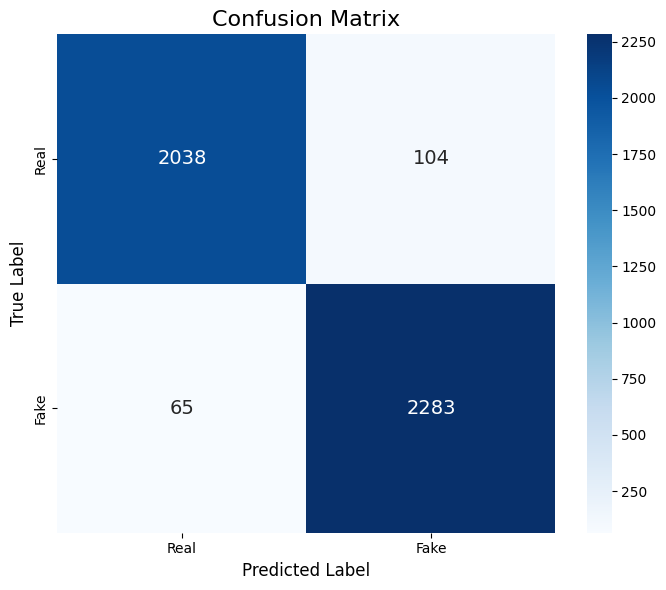


[Info] 'history.json' not found. Skipping training curve plots (expected after K-Fold).


In [ ]:
# 3: EVALUATING THE LOADED MODEL
print("\n 3: Evaluating Model Performance on Test Set ")

# Define where to save evaluation reports
REPORTS_DIR = ARTIFACTS_DIR / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Convert X_test to a list
X_test_list = [str(text) for text in X_test.tolist()]

# Tokenize the cleaned list of strings
X_test_token = tokenizer(
    X_test_list,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

print("Making predictions on the test set...")

test_probabilities = model.predict(dict(X_test_token), batch_size=32).flatten()
test_predictions = (test_probabilities >= threshold).astype(int)
true_labels = np.array(Y_test).flatten()

# Generate and Save Evaluation Reports
print("\n--- Classification Report (Test Set) ---")
report_str = classification_report(true_labels, test_predictions, target_names=['Real News (0)', 'Fake News (1)'])
print(report_str)
(REPORTS_DIR / "classification_report.txt").write_text(report_str)

print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(true_labels, test_predictions)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], annot_kws={"size": 14})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "confusion_matrix.png", dpi=150)
plt.show()

# Plotting training history if available
history_path = ARTIFACTS_DIR / "history.json"
if history_path.exists():
    print("\n[Info] 'history.json' found. Plotting training curves...")
else:
    print("\n[Info] 'history.json' not found. Skipping training curve plots (expected after K-Fold).")

In [ ]:
# 4: GRADIO INTERFACE FOR INTERACTIVE PREDICTION
print("\n 4: Launching Gradio Interface")

# Import the gradio library
import gradio as gr

def predict_news(text):

    # 1. Clean and prepare the input text
    cleaned_text = clean_text(text)

    # 2. Tokenize the text for the model
    inputs = tokenizer(
        [cleaned_text],  # The tokenizer expects a list of strings
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # 3. Use the loaded model to make a prediction
    probability = model.predict(dict(inputs), verbose=0).flatten()[0]

    # 4. Format the output for Gradio's Label component
    if probability >= threshold:
        return {'Fake News': float(probability), 'Real News': 1 - float(probability)}
    else:
        return {'Real News': 1 - float(probability), 'Fake News': float(probability)}

# Define the Gradio Interface layout and components
iface = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(
        lines=15,
        placeholder="Paste the full text of a news article here...",
        label="News Article Text"
    ),
    outputs=gr.Label(
        num_top_classes=2,
        label="Prediction Results"
    ),
    title=" Fake News Detector",
    description="An AI-powered tool to help distinguish between real and fake news. "
                "This model uses a BERT and CNN architecture to analyze the text. "
                "Enter an article below to see its classification.",
    examples=[
        ["The president announced today a new policy that will boost the economy."],
        ["Global markets reacted to the central bank's announcement of an interest rate hike on Tuesday, with the Dow Jones Industrial Average falling by over 200 points in early trading. Analysts are watching commodity prices closely."]
    ],
    allow_flagging="never"
)

# Launch the interactive interface
iface.launch(debug=True)


 4: Launching Gradio Interface


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:414: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://af03a5ad5f03e28252.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://af03a5ad5f03e28252.gradio.live
